In [1]:
from __future__ import print_function
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


from detectron2.data import DatasetCatalog
from detectron2.data.datasets import load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, verify_results
from detectron2.utils.logger import setup_logger

import copy
import logging
from typing import Any, Dict, Tuple
import torch
from fvcore.common.file_io import PathManager

from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.layers import ROIAlign
from detectron2.structures import BoxMode

#from densepose import DatasetMapper, DensePoseCOCOEvaluator, add_densepose_config
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper

from detectron2.data import detection_utils as utils

from fvcore.transforms.transform import TransformList, Transform, NoOpTransform


1.5.1+cu101
0.6.1+cu101
CUDA is available!  Training on GPU ...


In [4]:
for d in ["Training", "Validation"]:
    #DatasetCatalog.register("myuav1_" + d, lambda d=d: load_mycoco_json("/data/cmpe295-liu/UAVision/VisDrone2019-DET-" + d + "/annotations.json", "/data/cmpe295-liu/UAVision/VisDrone2019-DET-" + d + "/images", extrakeys))
    DatasetCatalog.register("mywaymo1_" + d, lambda d=d: load_coco_json("/data/cmpe295-liu/Waymo/WaymoCOCOsmall/" + d + "/annotations.json", "/data/cmpe295-liu/Waymo/WaymoCOCOsmall/" + d + "/"))

FULL_LABEL_CLASSES = ['unknown', 'vehicle', 'pedestrian', 'sign', 'cyclist']#['ignored-regions', 'pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle','bus',  'motor', 'others']
for d in ["Training", "Validation"]:
    MetadataCatalog.get("mywaymo1_" + d).set(thing_classes=FULL_LABEL_CLASSES)

In [7]:
cfg = get_cfg()
cfg.OUTPUT_DIR='./output' #'./output_x101'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")) #faster_rcnn_R_101_FPN_3x.yaml, faster_rcnn_X_101_32x8d_FPN_3x
cfg.DATASETS.TRAIN = ("mywaymo1_Training",)
cfg.DATASETS.TEST = ("mywaymo1_Validation",)
cfg.DATALOADER.NUM_WORKERS = 1 #2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join('/home/010796032/PytorchWork', "fasterrcnn_x101_fpn_model_final_68b088.pkl")#using the local 
cfg.MODEL.WEIGHTS = os.path.join('/home/010796032/PytorchWork/output', "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.LR_SCHEDULER_NAME='WarmupCosineLR'
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 80000# 140000    # you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #512#128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12  # Kitti has 9 classes (including donot care)

cfg.TEST.EVAL_PERIOD = 5000

predictor = DefaultPredictor(cfg)

In [9]:
evaluator = COCOEvaluator("mywaymo1_Validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "mywaymo1_Validation")
inference_on_dataset(predictor.model, val_loader, evaluator)

[09/15 14:29:15 d2.data.datasets.coco]: Loaded 1960 images in COCO format from /data/cmpe295-liu/Waymo/WaymoCOCOsmall/Validation/annotations.json
[09/15 14:29:16 d2.data.common]: Serializing 1960 elements to byte tensors and concatenating them all ...
[09/15 14:29:16 d2.data.common]: Serialized dataset takes 1.83 MiB
[09/15 14:29:16 d2.evaluation.evaluator]: Start inference on 1960 images
[09/15 14:29:18 d2.evaluation.evaluator]: Inference done 11/1960. 0.2075 s / img. ETA=0:06:46
[09/15 14:29:24 d2.evaluation.evaluator]: Inference done 34/1960. 0.2082 s / img. ETA=0:07:02
[09/15 14:29:29 d2.evaluation.evaluator]: Inference done 58/1960. 0.2082 s / img. ETA=0:06:49
[09/15 14:29:34 d2.evaluation.evaluator]: Inference done 82/1960. 0.2080 s / img. ETA=0:06:41
[09/15 14:29:39 d2.evaluation.evaluator]: Inference done 106/1960. 0.2080 s / img. ETA=0:06:34
[09/15 14:29:44 d2.evaluation.evaluator]: Inference done 128/1960. 0.2080 s / img. ETA=0:06:34
[09/15 14:29:49 d2.evaluation.evaluator]: 

OrderedDict([('bbox',
              {'AP': 16.841387676650594,
               'AP50': 35.92218154506198,
               'AP75': 13.384348630055568,
               'APs': 3.5517941106991393,
               'APm': 20.83071031961247,
               'APl': 52.084668848688956,
               'AP-unknown': nan,
               'AP-vehicle': 29.002431801959,
               'AP-pedestrian': 16.683572853712494,
               'AP-sign': nan,
               'AP-cyclist': 4.838158374280287})])

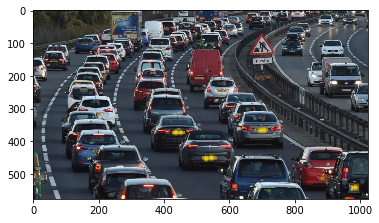

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
im = cv2.imread("./traffic.jpg")
imgrgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#plt.imshow(im)
plt.imshow(imgrgb)
plt.show()

In [12]:
outputs = predictor(im)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([[6.0879e+02, 3.0713e+02, 7.6171e+02, 4.2405e+02],
        [3.5781e+02, 3.1731e+02, 5.1688e+02, 4.3511e+02],
        [9.6937e+02, 2.2066e+02, 1.0240e+03, 3.0981e+02],
        [7.8921e+02, 4.1140e+02, 9.4821e+02, 5.5046e+02],
        [5.6877e+02, 4.3315e+02, 7.9856e+02, 5.7596e+02],
        [2.4899e+02, 5.0729e+02, 4.4669e+02, 5.7562e+02],
        [2.2330e+02, 0.0000e+00, 3.4071e+02, 1.3050e+02],
        [3.0203e+01, 1.1997e+02, 1.0850e+02, 1.8631e+02],
        [5.9073e+02, 2.7435e+02, 7.0933e+02, 3.8087e+02],
        [1.1269e+02, 3.5994e+02, 2.6156e+02, 4.9349e+02],
        [8.9156e+02, 4.2180e+02, 1.0240e+03, 5.7600e+02],
        [5.6625e+02, 2.4910e+02, 6.8889e+02, 3.4704e+02],
        [3.3699e+02, 3.1103e+01, 4.0109e+02, 8.8265e+01],
        [6.5899e+02, 1.4502e+01, 7.1064e+02, 5.9649e+01],
        [6.4314e+02, 5.2022e+02, 8.4617e+02, 5.7520e+02],
        [5.2158e+02, 2.0146e+02, 6.2787e+02, 3.0275e+02],
        [8.8101e+02, 1.4088e+02, 1.0071e+03, 2.6838e+02],
        

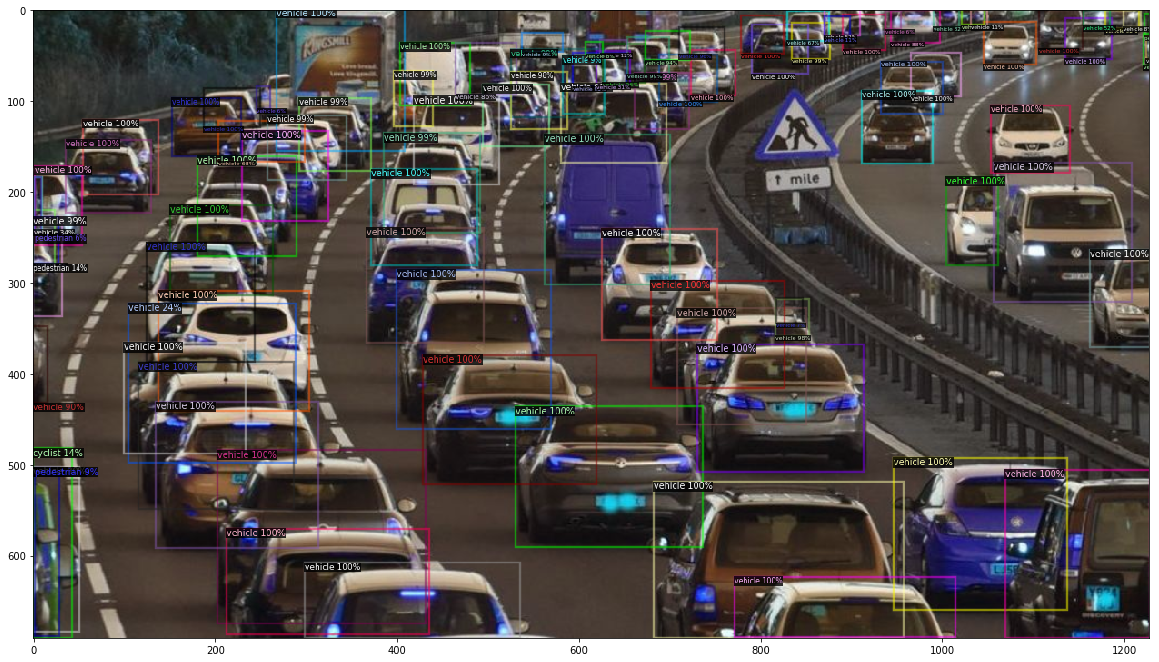

In [14]:
from detectron2.utils.visualizer import ColorMode
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,30)) # display the output image
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [ ]:
build_detection_test_loader